In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from helpFunctions import *
import os
import warnings
warnings.filterwarnings('ignore')
%pylab inline
%load_ext autoreload
%autoreload 2
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 12})
years, data, varNamesOverYears, varNamesOverYearsPlus = loadData()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# important variables
'''
    2002-2022 quarterly data
    "TOTAL ASSETS",
    "TOTAL EQUITY CAPITAL",
    "TOTAL LIABILITIES AND MINORITY INTEREST",
    "TOTAL DEPOSITS",
    "FEDERAL FUNDS SOLD", # short term borrowing
    "FEDERAL FUNDS PURCHASED IN DOMESTIC OFFICES", # short term lending
'''
importantVars = ["TOTAL ASSETS",
    "TOTAL EQUITY CAPITAL",
    "TOTAL LIABILITIES AND MINORITY INTEREST",
    "TOTAL DEPOSITS",
    "FEDERAL FUNDS SOLD",
    "SECURITIES SOLD UNDER AGREEMENTS TO REPURCHASE",
    "FEDERAL FUNDS PURCHASED IN DOMESTIC OFFICES",
    "SECURITIES PURCHASED UNDER AGREEMENTS TO RESELL"]
names = ["bank", "date", "assets", "equity", "liabilities", "deposit", "lending","shortLending","borrowing","shortBorrowing"]
    

In [3]:
# process all important variables in one big table
varTable = pd.DataFrame()
for year in years[1:]:
    df = pd.DataFrame()
    for var in importantVars:
        _, d = call([var], year, data = data, varNamesOverYears=varNamesOverYearsPlus)
        if df.size == 0:
            df = d
        else:
            df[var] = d[var]
    if varTable.size == 0:
        varTable = df
    varTable = pd.concat([varTable, df], axis = 0)
varTable.columns = names
varTable['date'] = pd.to_datetime(varTable['date'])

# clean some data points 
varTable = varTable[(varTable['assets'] >0) & 
                    (varTable['equity'] >0) & 
                    (varTable['liabilities'] >0) & 
                    (varTable['deposit'] >=0) & 
                    (varTable['lending'] >=0) & 
                    (varTable['shortLending'] >=0) & 
                    (varTable['borrowing'] >=0) &
                    (varTable['shortBorrowing'] >=0)
]
varTable.shape

(601433, 10)

In [4]:
import statsmodels.formula.api as smf
model = smf.ols("lending.div(assets) ~ equity.div(assets) + liabilities.div(assets) + deposit.div(assets)", data=varTable).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     lending.div(assets)   R-squared:                       0.038
Model:                             OLS   Adj. R-squared:                  0.038
Method:                  Least Squares   F-statistic:                     7818.
Date:                 Tue, 24 Jan 2023   Prob (F-statistic):               0.00
Time:                         17:00:34   Log-Likelihood:             8.4473e+05
No. Observations:               601433   AIC:                        -1.689e+06
Df Residuals:                   601429   BIC:                        -1.689e+06
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

In [5]:
model = smf.ols("borrowing.div(assets) ~ equity.div(assets) + liabilities.div(assets) + deposit.div(assets)", data=varTable).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     borrowing.div(assets)   R-squared:                       0.137
Model:                               OLS   Adj. R-squared:                  0.137
Method:                    Least Squares   F-statistic:                 3.170e+04
Date:                   Tue, 24 Jan 2023   Prob (F-statistic):               0.00
Time:                           17:00:34   Log-Likelihood:             1.3830e+06
No. Observations:                 601433   AIC:                        -2.766e+06
Df Residuals:                     601429   BIC:                        -2.766e+06
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [6]:
varTable["year"] = varTable.date.dt.year
varTable["leverage"] = varTable.assets/varTable.equity
ds = (varTable.assets/varTable.equity)
varYear = varTable[ds.between(0, ds.quantile(.99), inclusive=True)]
varYear.head()

,bank,date,assets,equity,liabilities,deposit,lending,shortLending,borrowing,shortBorrowing,year,leverage
0,BANK OF HANCOCK COUNTY,2002-12-31,74327.0,12561.0,61766.0,61501.0,7808,0.0,0,0.0,2002,5.917284
1,FIRST COMMUNITY BANK XENIA-FLORA,2002-12-31,25737.0,3856.0,21881.0,20614.0,943,0.0,0,0.0,2002,6.674533
2,"MINEOLA COMMUNITY BANK, SSB",2002-12-31,132091.0,17188.0,114903.0,77842.0,4190,0.0,0,0.0,2002,7.685071
3,BISON STATE BANK,2002-12-31,8408.0,1248.0,7160.0,7054.0,33,0.0,0,0.0,2002,6.737179
4,PEOPLES BANK,2002-12-31,150496.0,16944.0,133552.0,132029.0,3990,0.0,0,0.0,2002,8.881964


In [7]:
varYear.sort_values("assets", ascending=False)

,bank,date,assets,equity,liabilities,deposit,lending,shortLending,borrowing,shortBorrowing,year,leverage
12895,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",2022-03-31,3.476711e+09,299153000.0,3.177537e+09,2.635021e+09,0,152256000.0,620000,447187000.0,2022,11.621849
8052,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",2022-06-30,3.380824e+09,297245000.0,3.083483e+09,2.548727e+09,19000,142838000.0,1339000,438283000.0,2022,11.373863
3242,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",2022-09-30,3.308575e+09,297265000.0,3.011246e+09,2.502364e+09,14000,134598000.0,1492000,433351000.0,2022,11.130052
3304,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",2021-12-31,3.306982e+09,302848000.0,3.004113e+09,2.549631e+09,67000,121179000.0,1769000,386506000.0,2021,10.919610
8235,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",2021-09-30,3.290398e+09,296062000.0,2.994316e+09,2.499413e+09,0,138482000.0,2213000,376160000.0,2021,11.113882
...,...,...,...,...,...,...,...,...,...,...,...,...
16503,"FIRST TRUST COMPANY OF ONAGA, NATIONAL ASSOCIA...",2002-09-30,6.650000e+02,616.0,4.900000e+01,0.000000e+00,0,0.0,0,0.0,2002,1.079545
20726,MOUNT GILEAD SAVINGS AND LOAN ASSOCIATION,2014-03-31,3.200000e+02,304.0,1.600000e+01,1.100000e+01,0,0.0,0,0.0,2014,1.052632
24080,MONADNOCK COMMUNITY BANK,2013-03-31,2.000000e+02,107.0,9.300000e+01,0.000000e+00,0,0.0,0,0.0,2013,1.869159
4971,"CAMBRIDGE APPLETON TRUST, N.A.",2017-12-31,2.000000e+02,100.0,1.000000e+02,0.000000e+00,0,0.0,0,0.0,2017,2.000000


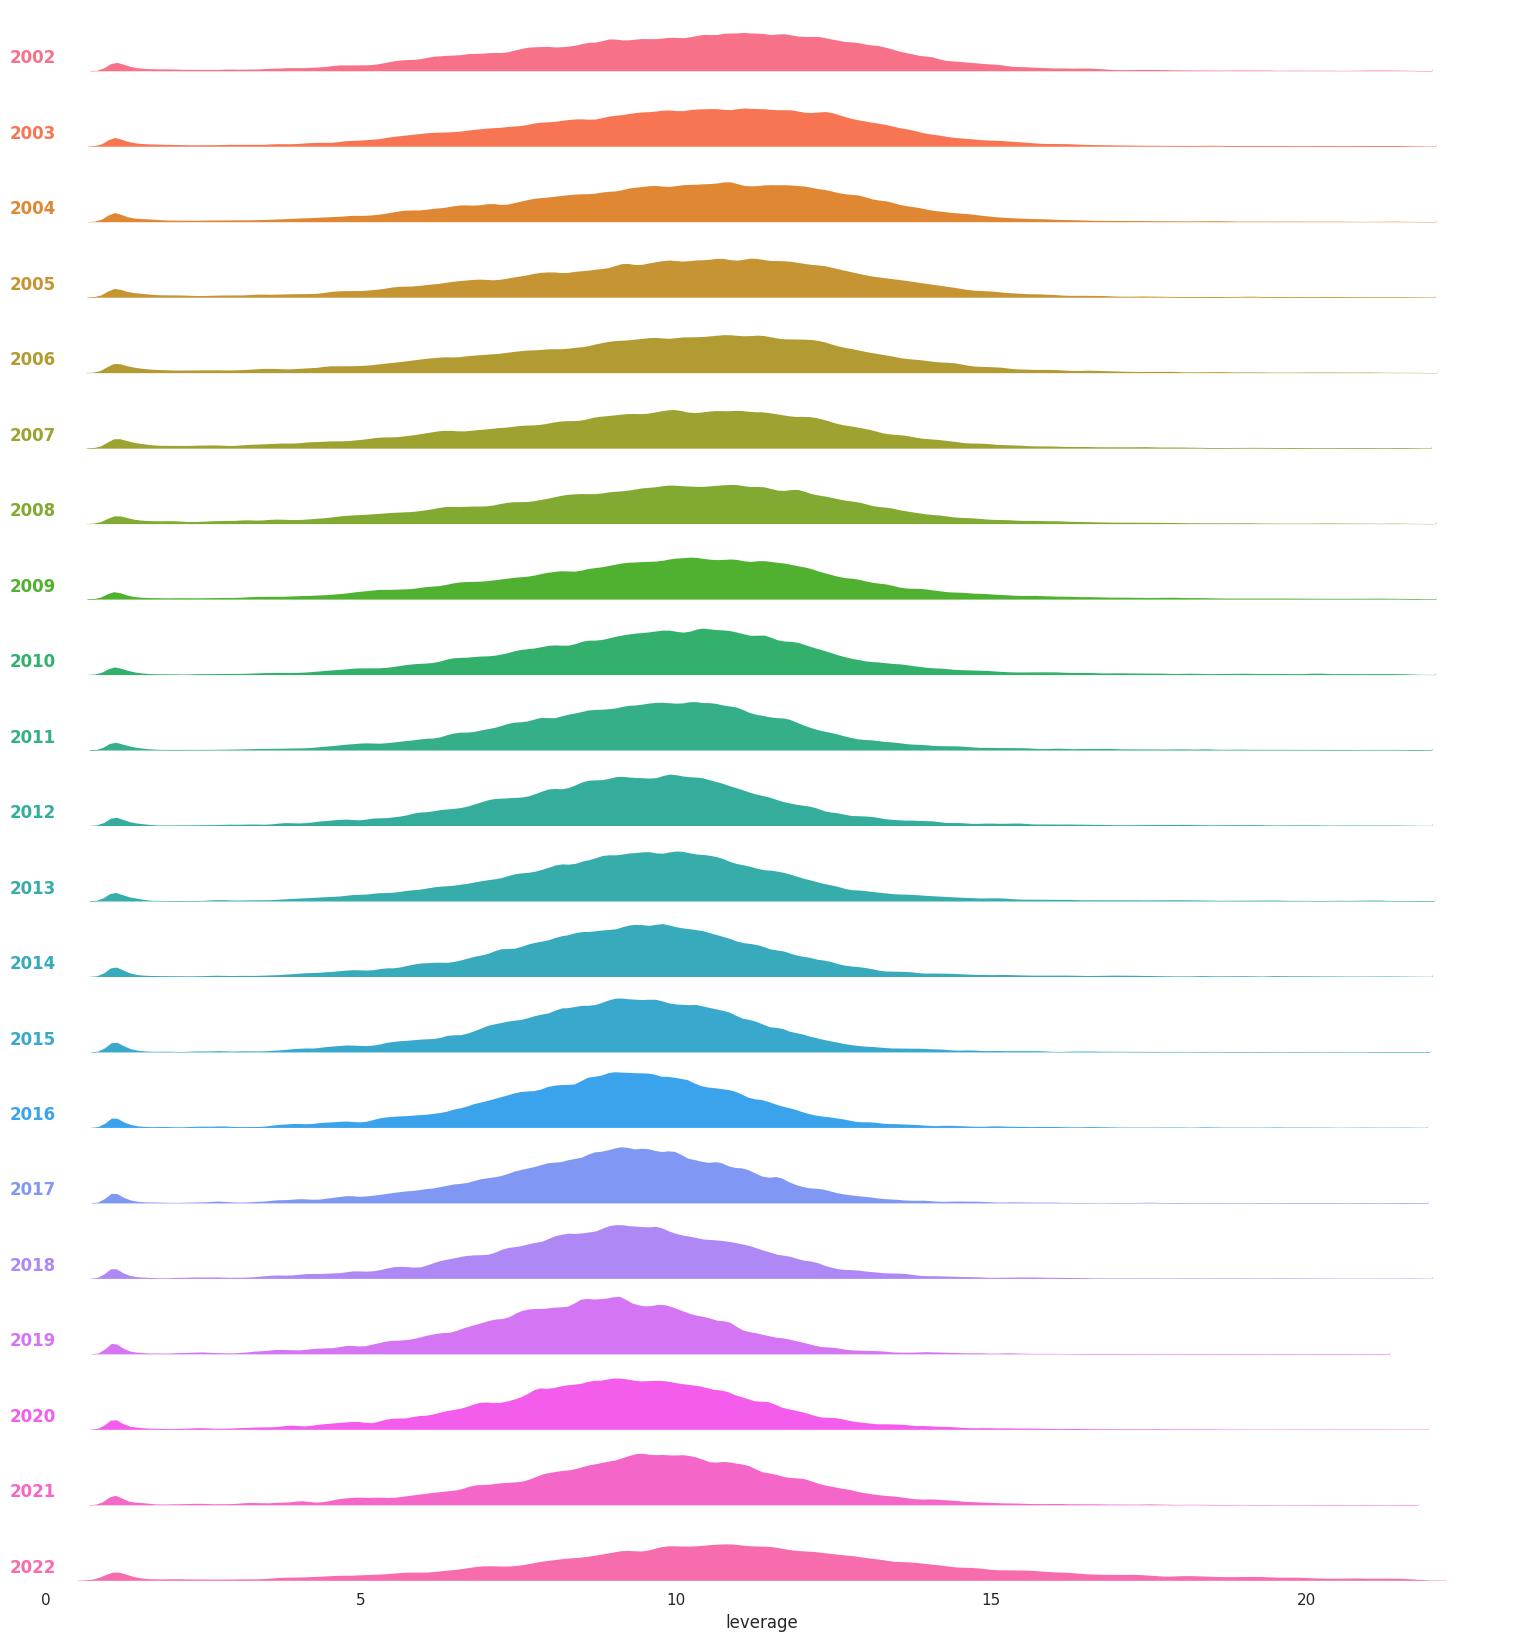

In [8]:
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
g = sns.FacetGrid(varYear, row="year", hue="year", aspect=20, height=0.8)

# Draw the densities in a few steps
g.map(sns.kdeplot, "leverage",
      bw_adjust=.3, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "leverage", clip_on=False, color="w", lw=2, bw_adjust=.3)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "leverage")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.show()

In [9]:
varYear.groupby("year")["leverage"].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2002,67656.0,10.142993,3.007230,1.000490,8.283624,10.385150,12.164367,21.691837
2003,33279.0,10.090159,2.976606,1.000604,8.291063,10.314051,12.083502,21.707058
2004,32659.0,10.020986,2.977088,1.000600,8.256361,10.258668,12.000223,21.706157
2005,32104.0,9.970246,3.028735,1.000753,8.157346,10.230837,11.961639,21.688034
2006,31704.0,9.842976,3.156593,1.000373,7.970665,10.112878,11.903112,21.712200
2007,31153.0,9.587514,3.097434,1.000690,7.760844,9.861944,11.632392,21.617682
2008,30524.0,9.714779,3.050636,1.000262,7.931855,9.954735,11.698856,21.696160
2009,29057.0,9.962737,2.996067,1.000074,8.189269,10.066609,11.723519,21.703970
2010,27722.0,9.887806,2.850125,1.000092,8.237345,9.945372,11.455930,21.703814


In [10]:
jpMorgan = varTable[varTable["bank"] == "JPMORGAN CHASE BANK, NATIONAL ASSOCIATION"].groupby("year").mean()
jpMorgan

,assets,equity,liabilities,deposit,lending,shortLending,borrowing,shortBorrowing,leverage
year,,,,,,,,,
2004,1.616433e+09,8.064000e+07,1.452441e+09,5.177100e+08,31459000.0,1.156250e+08,1.541500e+07,168096000.0,20.045052
2005,1.625699e+09,8.404950e+07,1.454423e+09,5.363348e+08,29716750.0,1.416470e+08,9.046750e+06,237937750.0,19.348519
2006,1.799386e+09,9.119800e+07,1.613735e+09,6.184430e+08,28087750.0,2.235220e+08,1.053400e+07,305405250.0,19.742791
2007,1.974604e+09,1.013722e+08,1.768879e+09,6.948790e+08,18751750.0,2.163818e+08,1.650175e+07,293474500.0,19.478978
2008,1.575234e+09,1.180522e+08,1.456066e+09,9.182875e+08,8431500.0,2.195212e+08,1.939100e+07,385101000.0,13.305424
2009,2.751968e+09,1.292545e+08,2.491834e+09,9.851792e+08,13425750.0,3.527698e+08,1.100200e+07,279769500.0,21.291334
2010,2.637505e+09,1.284155e+08,2.380510e+09,9.984568e+08,288250.0,2.919948e+08,1.088700e+07,294701750.0,20.557805
2011,1.788146e+09,1.271920e+08,1.660774e+09,1.149762e+09,453000.0,2.706368e+08,8.387250e+06,305551250.0,14.059753
2012,1.850596e+09,1.395748e+08,1.710796e+09,1.196130e+09,415000.0,2.531110e+08,2.697000e+06,353337000.0,13.269163


In [11]:
df = varYear[varYear.date == "2022-03-31"].groupby("bank").mean()
df = df.sort_values("assets", ascending = False).reset_index()
df

,bank,assets,equity,liabilities,deposit,lending,shortLending,borrowing,shortBorrowing,year,leverage
0,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",3.476711e+09,299153000.0,3.177537e+09,2.635021e+09,0.0,152256000.0,620000.0,447187000.0,2022.0,11.621849
1,"BANK OF AMERICA, NATIONAL ASSOCIATION",2.513619e+09,229392000.0,2.284227e+09,2.150323e+09,0.0,67248000.0,0.0,49530000.0,2022.0,10.957745
2,"WELLS FARGO BANK, NATIONAL ASSOCIATION",1.764272e+09,165473000.0,1.598770e+09,1.518051e+09,86000.0,10225000.0,209000.0,139762000.0,2022.0,10.661993
3,"CITIBANK, N.A.",1.718008e+09,164175000.0,1.553232e+09,1.373373e+09,0.0,24283000.0,0.0,98626000.0,2022.0,10.464492
4,U.S. BANK NATIONAL ASSOCIATION,5.775439e+08,45596405.0,5.313099e+08,4.730535e+08,7457.0,1686508.0,651109.0,0.0,2022.0,12.666436
...,...,...,...,...,...,...,...,...,...,...,...
4190,DSRM NATIONAL BANK,4.063000e+03,3401.0,6.620000e+02,5.000000e+02,0.0,0.0,0.0,0.0,2022.0,1.194649
4191,CANANDAIGUA NATIONAL TRUST COMPANY OF FLORIDA,3.957000e+03,3759.0,1.980000e+02,0.000000e+00,0.0,0.0,0.0,0.0,2022.0,1.052674
4192,"WHEATON COLLEGE TRUST COMPANY, NATIONAL ASSOCI...",3.795000e+03,3656.0,1.390000e+02,0.000000e+00,0.0,0.0,0.0,0.0,2022.0,1.038020
4193,EMIGRANT MERCANTILE BANK,3.383000e+03,2881.0,5.020000e+02,5.000000e+02,0.0,0.0,0.0,0.0,2022.0,1.174245


In [13]:
(df["deposit"] / df["assets"]).describe()

count    4195.000000
mean        0.850819
std         0.131419
min         0.000000
25%         0.844765
50%         0.880572
75%         0.905028
max         0.953566
dtype: float64

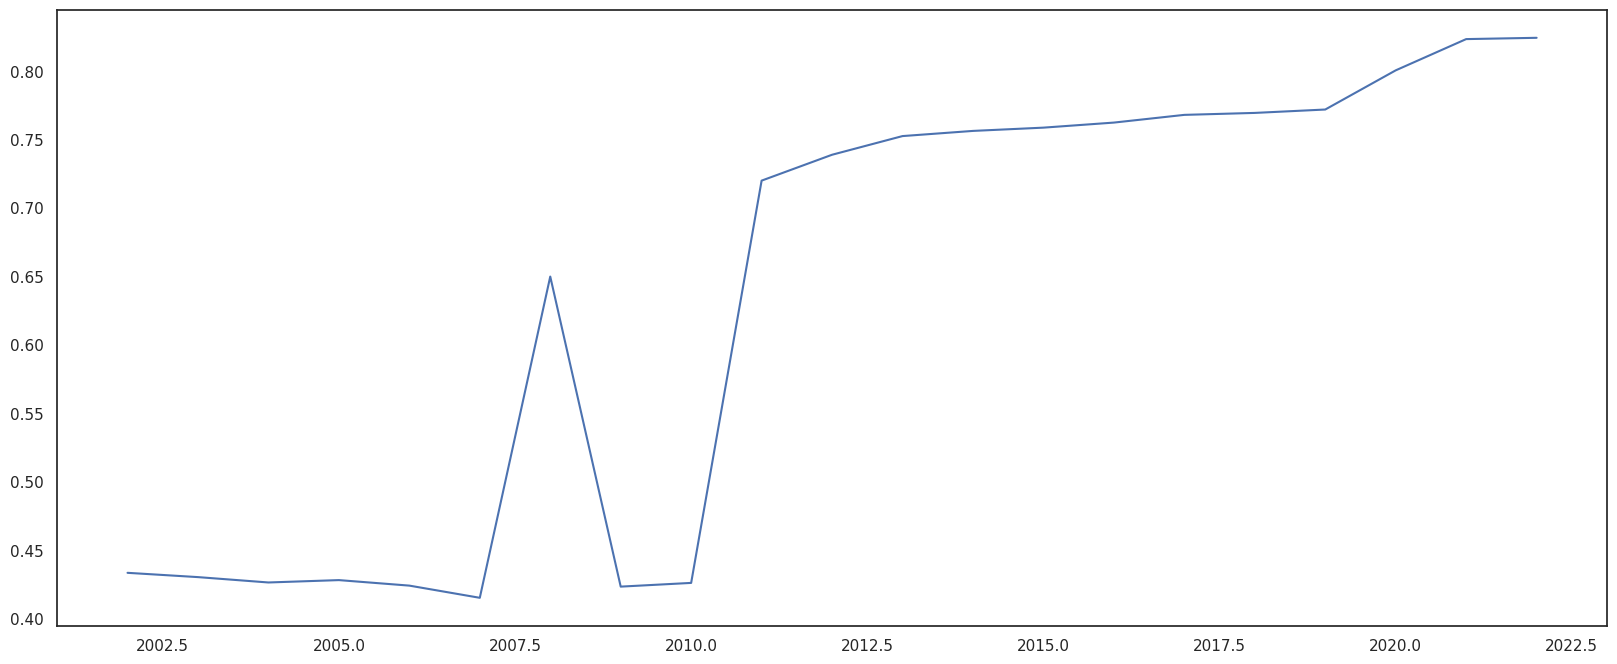

In [12]:
plt.plot(varTable.groupby("year")["deposit"].sum() / varTable.groupby("year")["assets"].sum(), label = "deposit/liabilities")

<AxesSubplot: xlabel='year'>

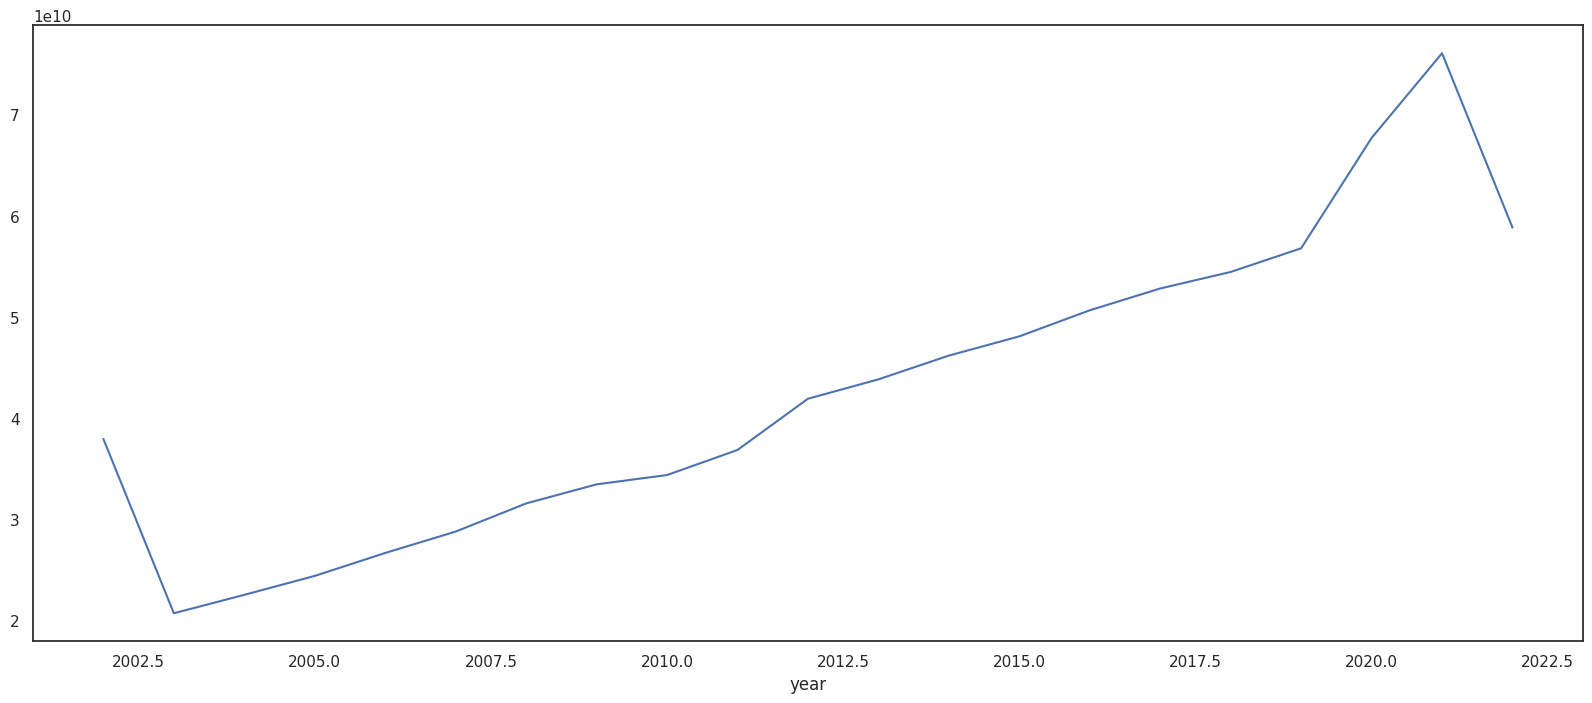

In [13]:
varTable.groupby("year")["deposit"].sum().plot()

In [94]:
def bigVsSmall(varTable, varName):
    bigs = []
    smalls = []
    for year in range(2002, 2023):
        big20 = varTable.groupby("bank")["assets"].sum().sort_values(ascending = False).head(20).index.values
        big = varTable[(varTable.date.dt.year == year)& varTable["bank"].isin(big20)][varName].mean()
        small = varTable[(varTable.date.dt.year == year)& ~varTable["bank"].isin(big20)][varName].mean()
        bigs.append(big)
        smalls.append(small)
    plt.plot(range(2002, 2023),bigs, label = "big")
    plt.plot(range(2002, 2023),smalls, label = "small")
    plt.xticks(range(2002, 2023))
    plt.legend()

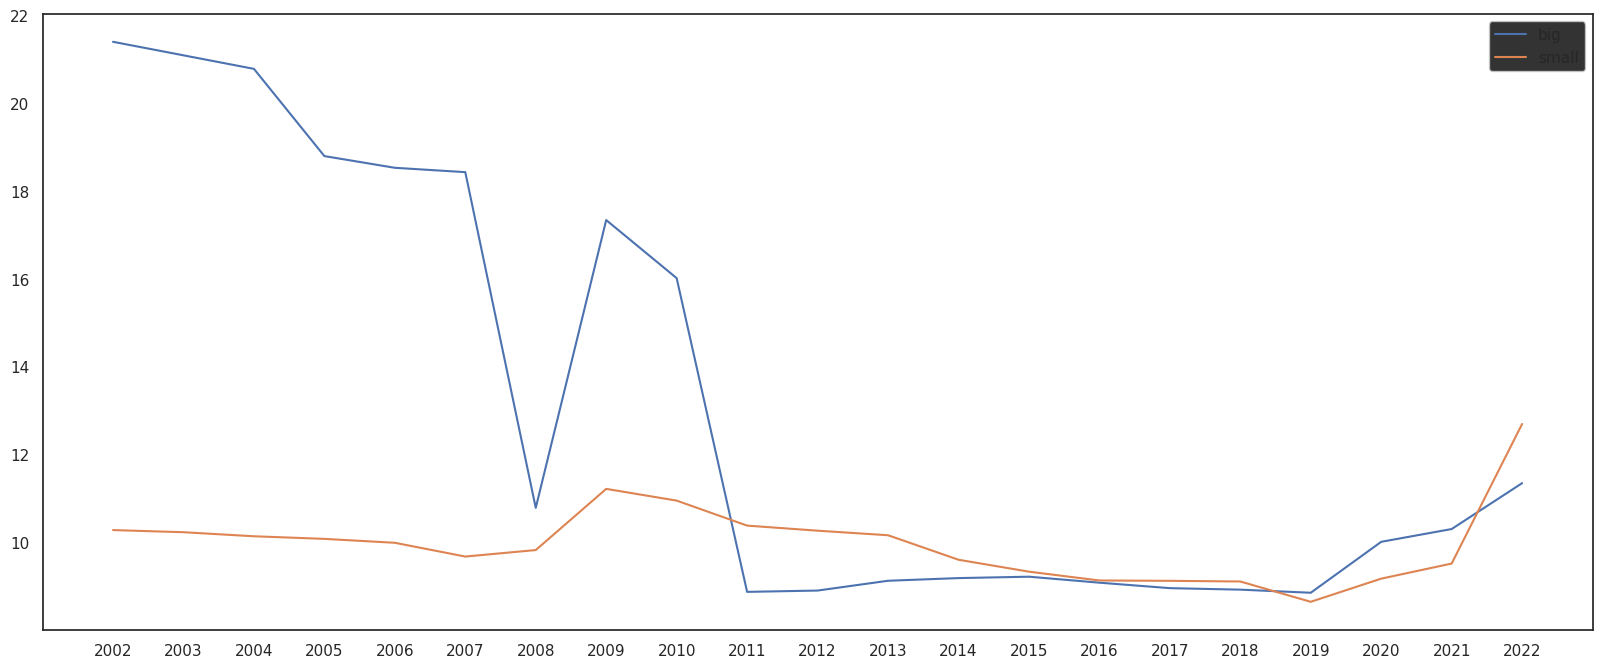

In [95]:
bigVsSmall(varTable, "leverage")

In [102]:
def bigVsSmallRatio(varTable, varName, varName2):
    bigs = []
    smalls = []
    for year in range(2002, 2023):
        big20 = varTable.groupby("bank")["assets"].sum().sort_values(ascending = False).head(20).index.values
        big = (varTable[(varTable.date.dt.year == year)& varTable["bank"].isin(big20)][varName] /
                varTable[(varTable.date.dt.year == year)& varTable["bank"].isin(big20)][varName2]).mean()
        small = (varTable[(varTable.date.dt.year == year)& ~varTable["bank"].isin(big20)][varName]/
                 varTable[(varTable.date.dt.year == year)& ~varTable["bank"].isin(big20)][varName2]).mean()
        bigs.append(big)
        smalls.append(small)
    plt.plot(range(2002, 2023),bigs, label = "big")
    plt.plot(range(2002, 2023),smalls, label = "small")
    plt.xticks(range(2002, 2023))
    plt.legend()

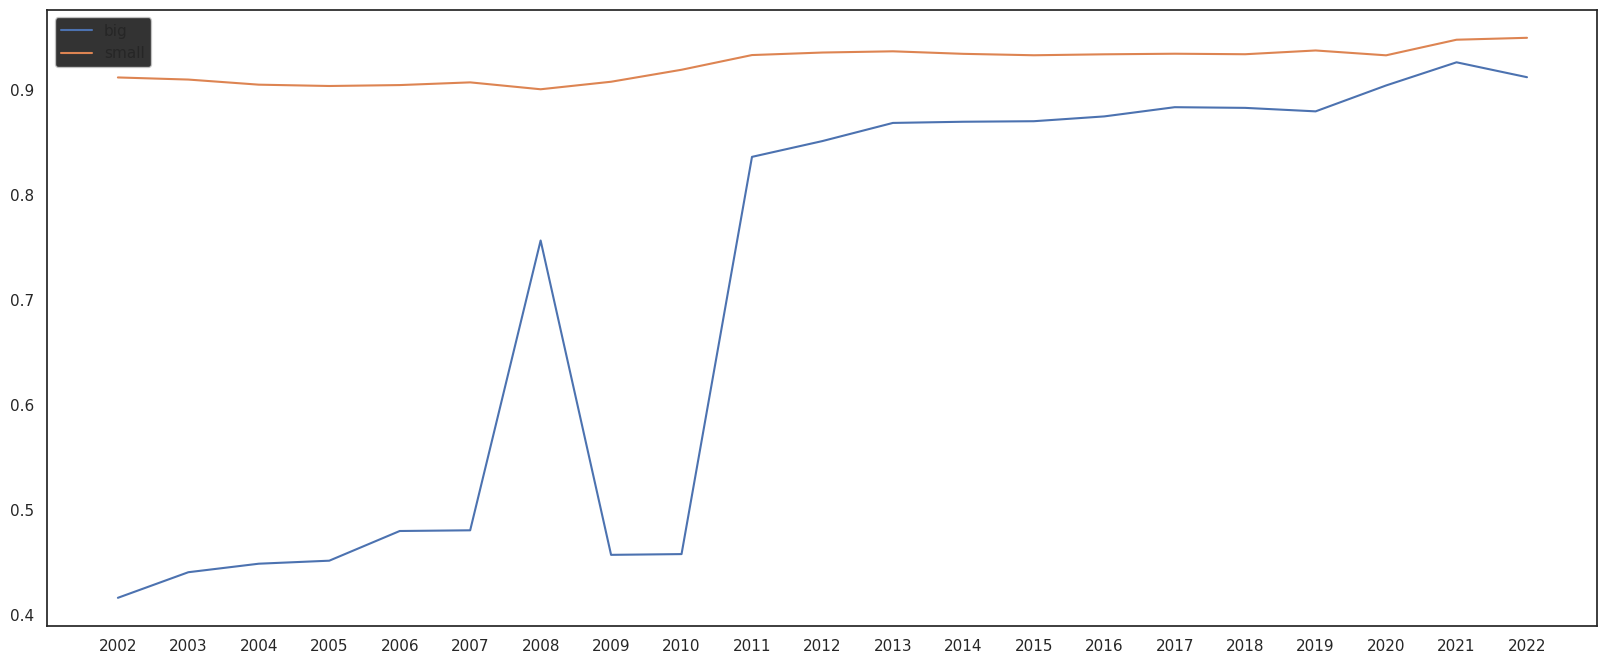

In [98]:
bigVsSmallRatio(varTable, "deposit", "liabilities")

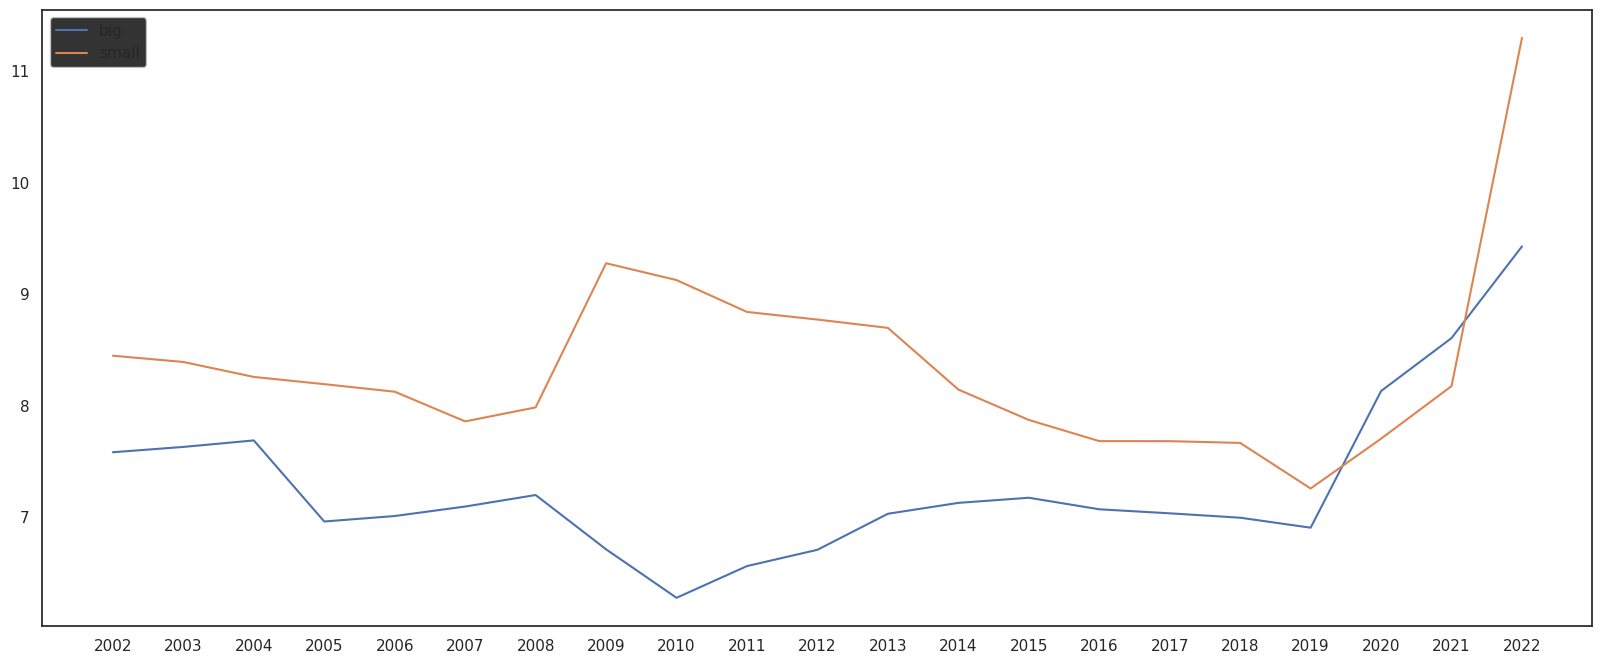

In [99]:
bigVsSmallRatio(varTable, "deposit", "equity")

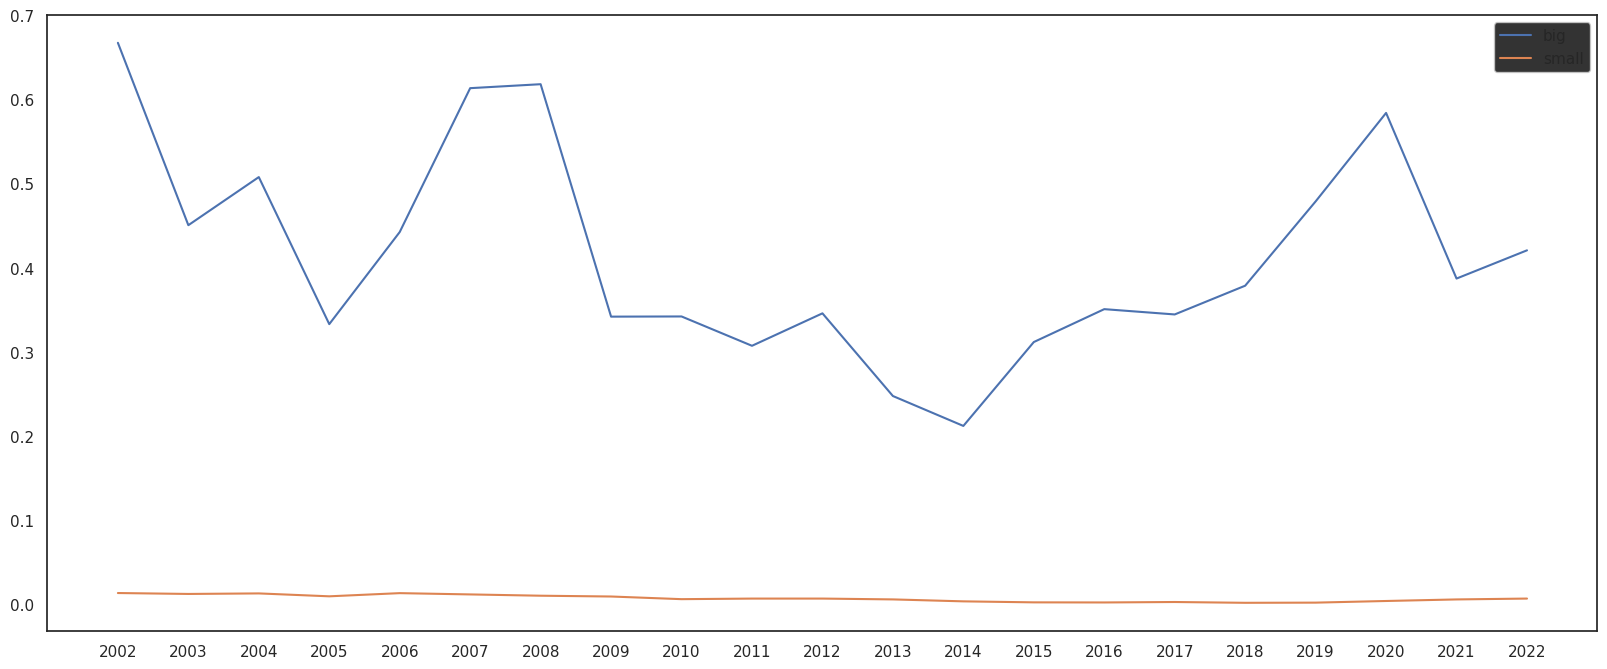

In [114]:
bigVsSmallRatio(varTable, "shortBorrowing", "equity")

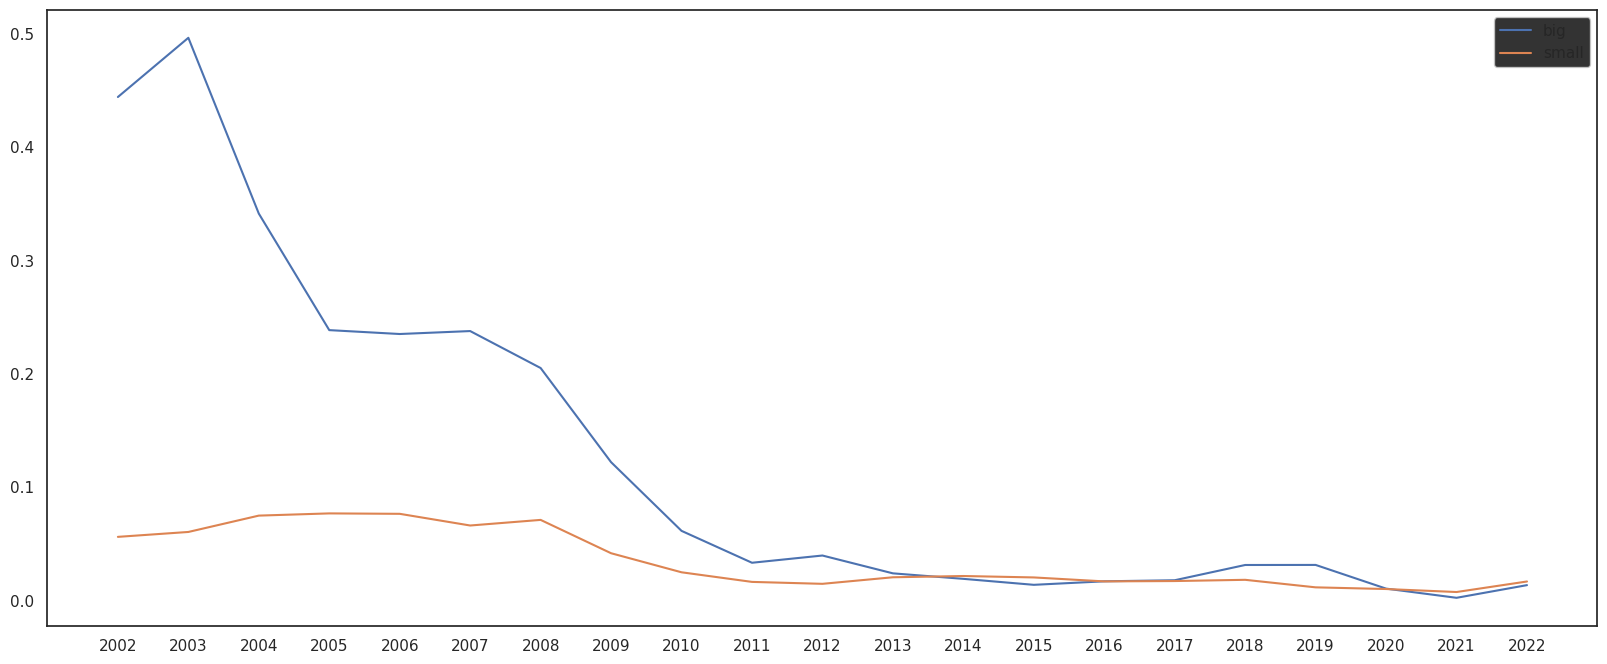

In [100]:
bigVsSmallRatio(varTable, "borrowing", "equity")

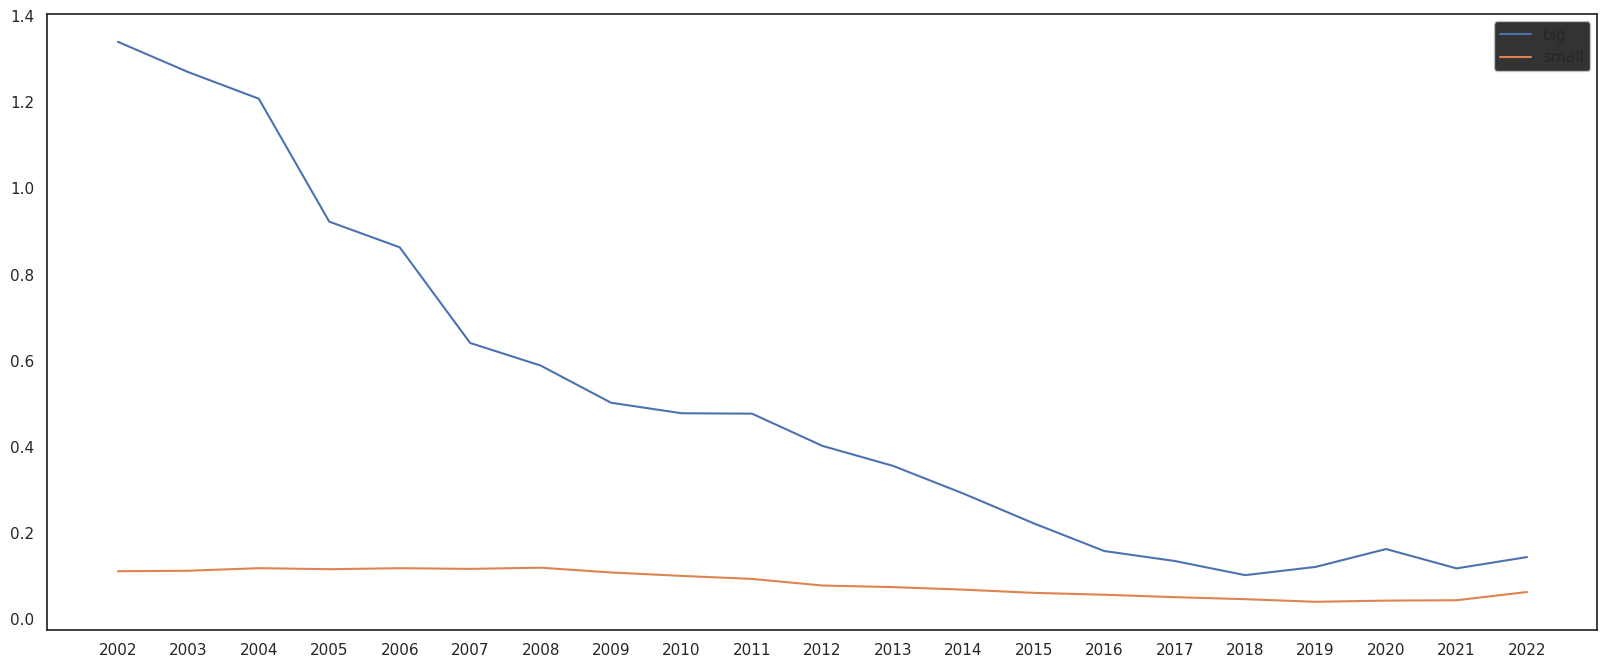

In [115]:
bigVsSmallRatio(varTable, "shortLending", "equity")

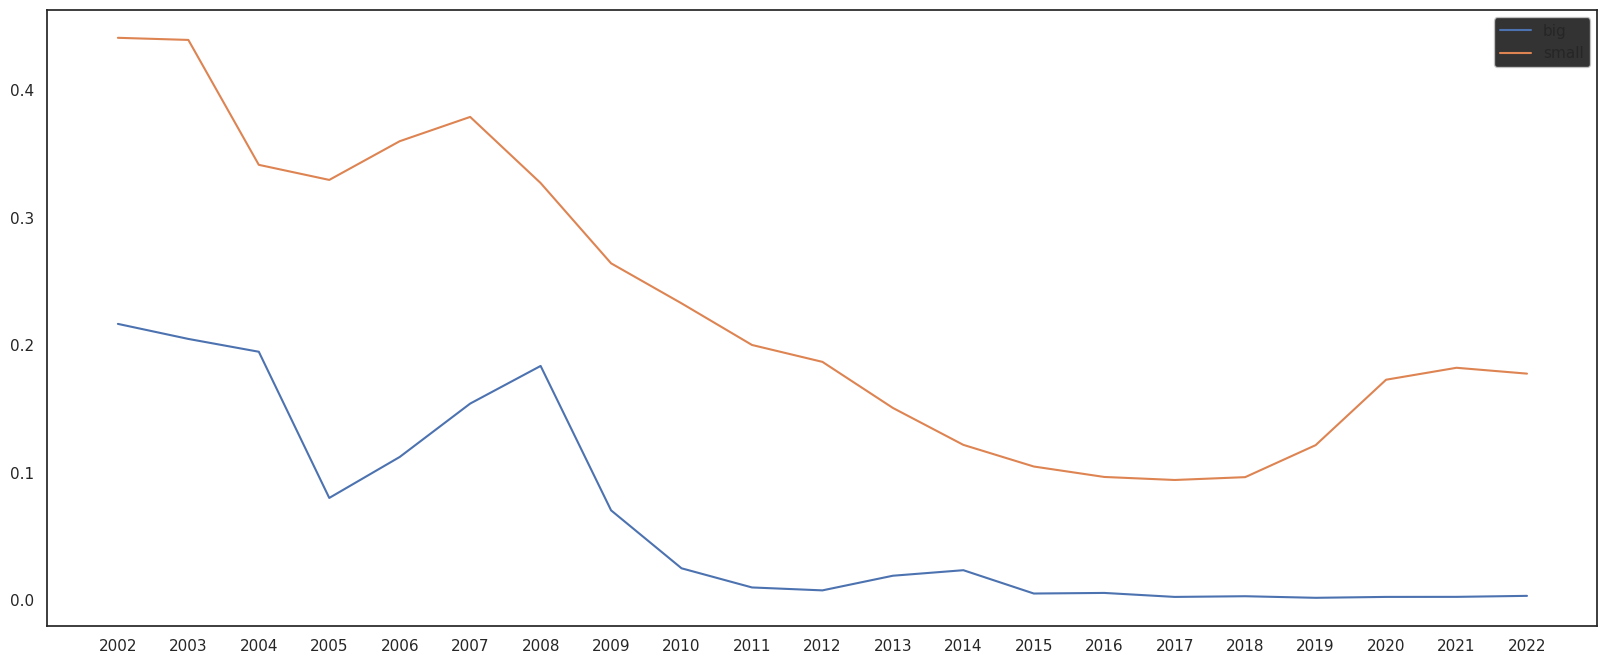

In [101]:
bigVsSmallRatio(varTable, "lending", "equity")

In [15]:
df = varYear[varYear.date == "2022-03-31"].groupby("bank").mean()
df = df.sort_values("assets", ascending = False).reset_index()
df.to_csv("banksData_2022.csv")